Importing libraries

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

Step 1: Loading data

In [4]:
df = pd.read_csv('data.csv', sep=';')
print("Размер:", df.shape)  # (4424, 37)
print(df.head())
print(df['Target'].value_counts())

Размер: (4424, 37)
   Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3                             1                       1   
4                             0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2      

Step 2: Preprocessing

In [5]:
df.drop_duplicates(inplace=True)
df['Age at enrollment'] = np.clip(df['Age at enrollment'], None, 50)

Feature engineering

In [7]:
df['Success_rate_1st'] = df['Curricular units 1st sem (approved)'] / (df['Curricular units 1st sem (enrolled)'] + 1e-6)
df['Success_rate_2nd'] = df['Curricular units 2nd sem (approved)'] / (df['Curricular units 2nd sem (enrolled)'] + 1e-6)

df['Target_binary'] = (df['Target'] == 'Dropout').astype(int)

df.to_csv('cleaned_student_dropout.csv', index=False)

X = df.drop(['Target', 'Target_binary'], axis=1)
y = df['Target_binary']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)

Step 3: EDA

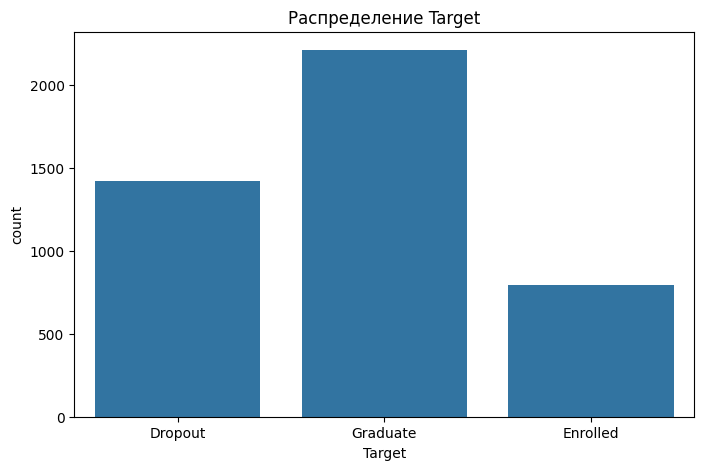

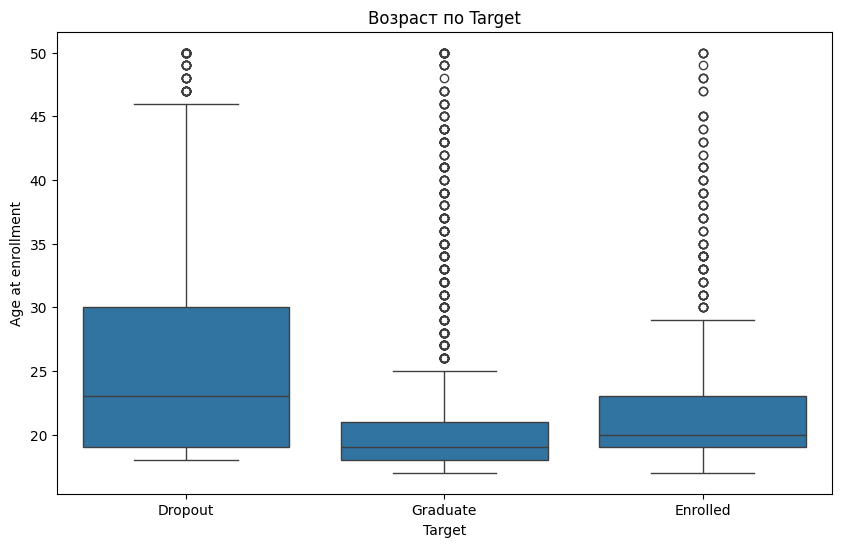

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


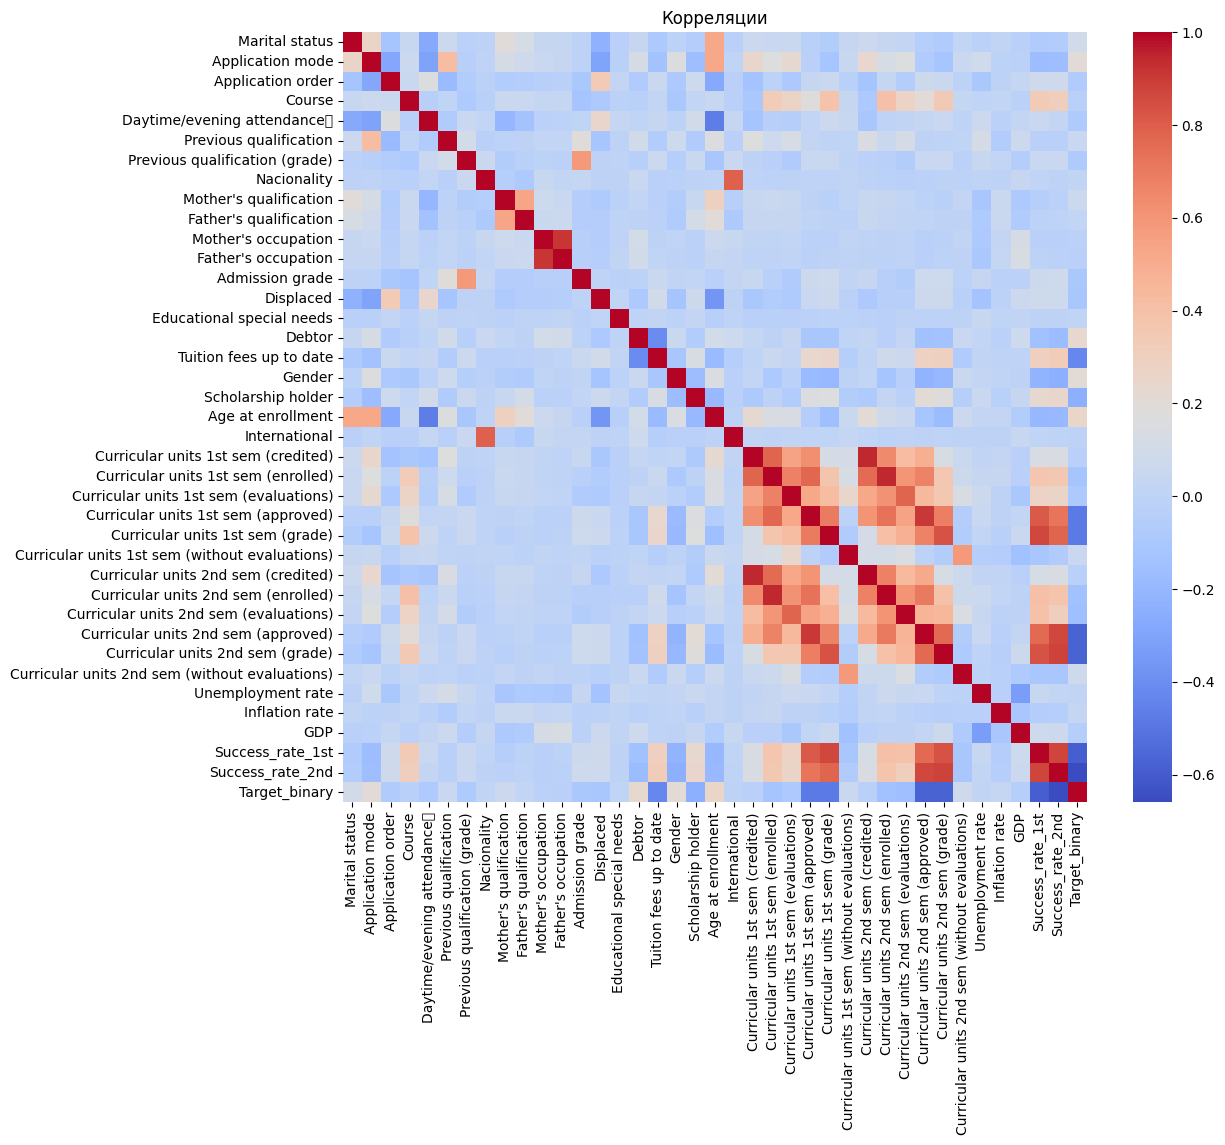

In [8]:
plt.figure(figsize=(8,5))
sns.countplot(x='Target', data=df)
plt.title('Распределение Target')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='Target', y='Age at enrollment', data=df)
plt.title('Возраст по Target')
plt.show()

corr = df[num_cols + ['Target_binary']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Корреляции')
plt.show()

Step 4: Models

Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       601
           1       0.89      0.74      0.81       284

    accuracy                           0.89       885
   macro avg       0.89      0.85      0.86       885
weighted avg       0.89      0.89      0.88       885

ROC-AUC LR: 0.9265016053057112
Random Forest (best: {'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 300} )
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       601
           1       0.87      0.75      0.81       284

    accuracy                           0.88       885
   macro avg       0.88      0.85      0.86       885
weighted avg       0.88      0.88      0.88       885

ROC-AUC RF: 0.9366255770898269


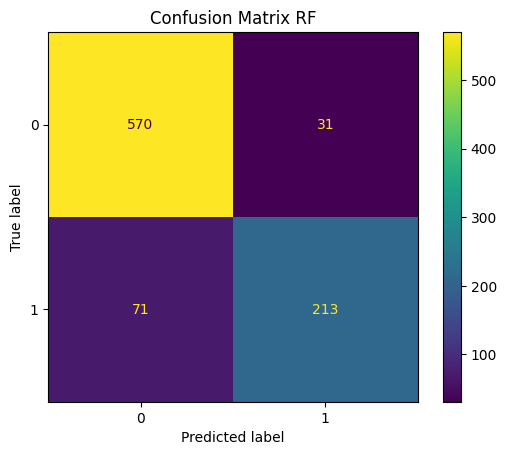

In [9]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC LR:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

rf = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators': [200, 300], 'max_depth': [15, 25, None], 'class_weight': ['balanced']}
grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Random Forest (best:", grid.best_params_, ")")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC RF:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title('Confusion Matrix RF')
plt.show()

Feature importance

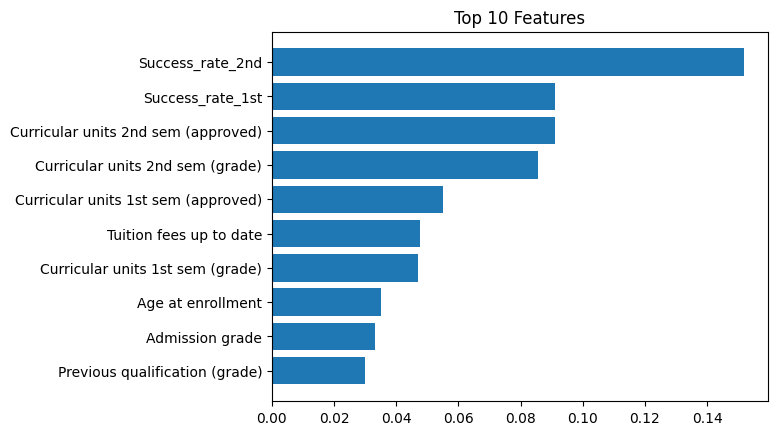

In [10]:
feature_names = preprocessor.get_feature_names_out()
importances = best_rf.feature_importances_
top_idx = np.argsort(importances)[-10:]
plt.barh(range(10), importances[top_idx])
plt.yticks(range(10), [name.split('__')[-1] for name in feature_names[top_idx]])
plt.title('Top 10 Features')
plt.show()